In [1]:
import os
import cv2
import json
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv
from sklearn import metrics

from src import scale_proportional
from src import binary, otsu, watershed, region_growing
import src.description as description


In [2]:
# !curl -o dataset.zip "https://database.cric.com.br/api/v1/imagens/export?collection=1&images=1&classifications=0&segmentations=0"
# !mkdir -p dataset
# !unzip -q dataset.zip -d dataset

In [3]:
df = pd.read_csv('./classifications.csv')
dir_path = './dataset'
test_img = '0a2a5a681410054941cc56f51eb8fbda.png'
df[df['image_filename'] == test_img]

,image_id,image_filename,image_doi,cell_id,bethesda_system,nucleus_x,nucleus_y
5635,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5636,Negative for intraepithelial lesion,1012,875
5636,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5637,Negative for intraepithelial lesion,910,900
5637,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5638,Negative for intraepithelial lesion,1177,416
5638,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5639,Negative for intraepithelial lesion,1254,366
5639,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5640,LSIL,983,450


In [4]:
def crop_image_around_point(image, x, y, crop_size):
    # Calculate the top-left corner of the crop
    x_start = max(0, x - int(crop_size / 2))
    y_start = max(0, y - int(crop_size / 2))

    # Calculate the bottom-right corner of the crop
    x_end = min(image.shape[1], x + int(crop_size / 2))
    y_end = min(image.shape[0], y + int(crop_size / 2))

    # Crop the image
    cropped_image = image[y_start:y_end, x_start:x_end]

    return cropped_image

In [5]:
def crop_with_pil(image, x, y, crop_size):
    lcrop = int(crop_size/2)
    rcrop = int(crop_size - lcrop)
    width, height = image.size

    # Calculate the top-left corner of the crop
    x_start = max(0, x - lcrop)
    y_start = max(0, y - lcrop)

    # Calculate the bottom-right corner of the crop
    x_end = min(width, x + rcrop)
    y_end = min(height, y + rcrop)

    # Crop the image
    cropped_image = image.crop((x_start, y_start, x_end, y_end))

    return cropped_image

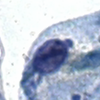

In [6]:
img_path = os.path.join(dir_path, test_img)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cropped_img = crop_image_around_point(image, 1012, 875, 100)
img = Image.fromarray(cropped_img)
img

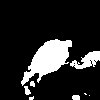

In [55]:
binary = binary(cropped_img, 127, invert=True)
Image.fromarray(binary)

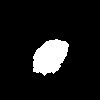

In [56]:
watershed_img = watershed(cropped_img)
Image.fromarray(watershed_img)

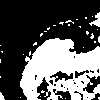

In [9]:
Image.fromarray(otsu(cropped_img, invert=True))

In [8]:
df = pd.read_csv('./main_data.csv')
df = df.drop(df.columns[[0]], axis=1)
df

,image,area,compactness,eccentricity,perimeter,label
0,./cropped_dataset/ASC-H/10.jpg,483,2.066071,0.511844,111.982755,ASC-H
1,./cropped_dataset/ASC-H/10000.jpg,673,2.907563,0.794802,156.811182,ASC-H
2,./cropped_dataset/ASC-H/10001.jpg,970,1.757551,0.497155,146.367531,ASC-H
3,./cropped_dataset/ASC-H/10002.jpg,731,1.570865,0.394551,120.124891,ASC-H
4,./cropped_dataset/ASC-H/10003.jpg,1063,1.394180,0.270889,136.468036,ASC-H
...,...,...,...,...,...,...
11529,./cropped_dataset/Negative for intraepithelial...,470,1.127330,0.478484,81.597979,Negative for intraepithelial lesion
11530,./cropped_dataset/Negative for intraepithelial...,327,1.050396,0.413155,65.698484,Negative for intraepithelial lesion
11531,./cropped_dataset/Negative for intraepithelial...,261,1.027138,0.314594,58.041630,Negative for intraepithelial lesion
11532,./cropped_dataset/Negative for intraepithelial...,835,1.574316,0.643762,128.526911,Negative for intraepithelial lesion


## Scatterplot (6)

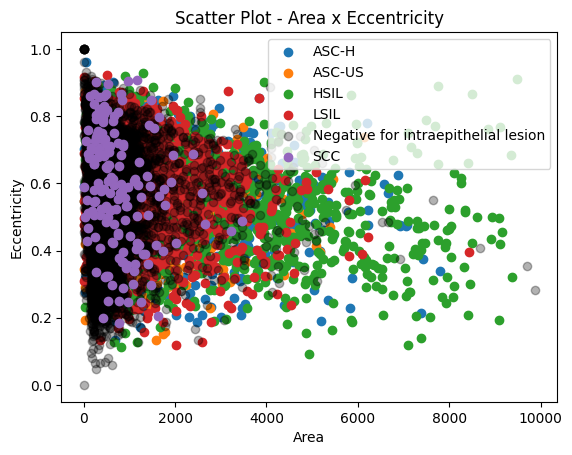

In [10]:
for label in np.unique(df['label']):
    if label == "Negative for intraepithelial lesion":
        plt.scatter(
            df[df['label'] == label]['area'], 
            df[df['label'] == label]['eccentricity'],
            alpha=.3, color='#000000')
    else:
        plt.scatter(
            df[df['label'] == label]['area'], 
            df[df['label'] == label]['eccentricity'],
            alpha=1)

plt.title('Scatter Plot - Area x Eccentricity')
plt.xlabel('Area')
plt.ylabel('Eccentricity')
plt.legend(np.unique(df['label']))
plt.savefig('./model_data/scatter_all.png')
plt.show()

## Separacao dados (7)

In [11]:
X = df.drop(['label', 'image'], axis=1)  # Features
y = df['label']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [12]:
np.unique(y_train, return_counts=True)[1]/np.unique(y_test, return_counts=True)[1]

array([4.        , 4.00826446, 3.9941349 , 4.        , 3.99926254,
       4.03125   ])

## Mahalanobis (8)

#### Negative x other

In [56]:
np.unique(y_train)

array(['ASC-H', 'ASC-US', 'HSIL', 'LSIL',
       'Negative for intraepithelial lesion', 'SCC'], dtype=object)

In [61]:
target_class = 'Negative for intraepithelial lesion'
mean_class_0 = X_train[y_train == target_class].mean()
mean_class_1 = X_train[y_train != target_class].mean()

covariance_class_0 = np.cov(X_train[y_train == target_class], rowvar=False)
covariance_class_1 = np.cov(X_train[y_train != target_class], rowvar=False)

inv_cov_class_0 = inv(covariance_class_0)
inv_cov_class_1 = inv(covariance_class_1)

In [62]:
mahalanobis_dist_target = np.apply_along_axis(
    lambda x: mahalanobis(x, mean_class_0, inv_cov_class_0),
    axis=1,
    arr=X_test
)

mahalanobis_dist_other = np.apply_along_axis(
    lambda x: mahalanobis(x, mean_class_1, inv_cov_class_1),
    axis=1,
    arr=X_test
)

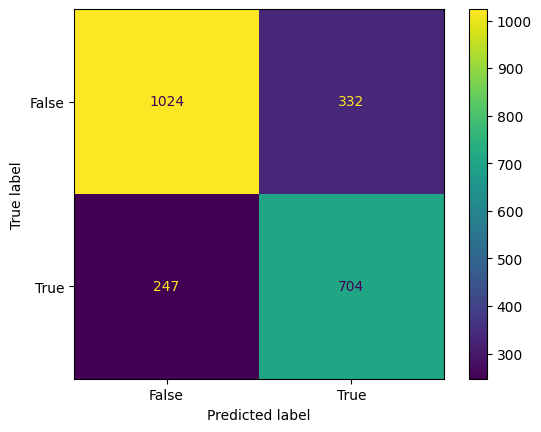

In [66]:
y_pred = np.where(mahalanobis_dist_target < mahalanobis_dist_other, 0, 1)
y_bin_test = np.where(y_test == target_class, 0, 1)

confusion_matrix = metrics.confusion_matrix(y_bin_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()


#### All classes

In [13]:
class_means = []
class_covariances = []
inv_cov_matrices = []

In [14]:
unique_classes = np.unique(y_train)
for class_label in unique_classes:
    class_data = X_train[y_train == class_label]
    class_means.append(np.mean(class_data, axis=0))
    class_covariances.append(np.cov(class_data, rowvar=False))
    inv_cov_matrices.append(inv(class_covariances[-1]))

In [15]:
mahalanobis_dists = np.zeros((len(X_test), len(unique_classes)))

In [40]:
unique_classes.tolist()

['ASC-H',
 'ASC-US',
 'HSIL',
 'LSIL',
 'Negative for intraepithelial lesion',
 'SCC']

In [41]:
test = [x.to_dict() for x in class_means]
with open("./model_data/mahalanobis/class_means.json", "w") as f:
    json.dump(test, f)

with open("./model_data/mahalanobis/labels.json", "w") as f:
    json.dump(unique_classes.tolist(), f)

test = [(x.tolist()) for x in inv_cov_matrices]
with open("./model_data/mahalanobis/inv_cov_matrices.json", "w") as f:
    json.dump(test, f)

In [44]:
with open("./model_data/mahalanobis/class_means.json", "r") as f:
    class_means = json.load(f)
    class_means = [pd.Series(series_dict) for series_dict in class_means]

with open("./model_data/mahalanobis/labels.json", "r") as f:
    unique_classes = json.load(f)

with open("./model_data/mahalanobis/inv_cov_matrices.json", "r") as f:
    inv_cov_matrices = json.load(f)

In [45]:
for i, class_label in enumerate(unique_classes):
    mahalanobis_dists[:, i] = np.apply_along_axis(
        lambda x: mahalanobis(x, class_means[i], inv_cov_matrices[i]),
        axis=1,
        arr=X_test
    )

In [48]:
mahalanobis_dists.shape

(2307, 6)

In [46]:
y_pred = np.argmin(mahalanobis_dists, axis=1)
y_pred = list(map(lambda x: unique_classes[x], y_pred))


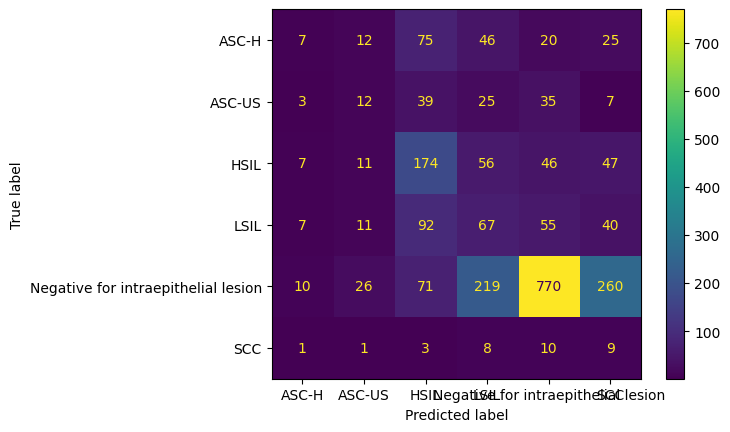

In [47]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = unique_classes)
cm_display.plot()
plt.show()


In [57]:
data = (
    description.calculate_area(watershed_img),
    description.calculate_compactness(watershed_img),
    description.calculate_eccentricity(watershed_img),
    description.calculate_perimeter(watershed_img)
)

In [58]:
data

(926, 1.3365537276220156, 0.5641397645686083, 124.71067678928375)

In [69]:
test = np.zeros((1, len(unique_classes))).astype(object)
for i, class_label in enumerate(unique_classes):
    test[:, i] = {class_label: mahalanobis(data, class_means[i], inv_cov_matrices[i])}

In [87]:
for i, key in enumerate(test[0]):
    print(i, key)

0 {'ASC-H': 1.0095576945182023}
1 {'ASC-US': 0.9775457824304492}
2 {'HSIL': 1.0981514278125166}
3 {'LSIL': 0.9135418744389565}
4 {'Negative for intraepithelial lesion': 1.0333296220657855}
5 {'SCC': 1.1995378445642182}
